In [82]:
import os
import json
import nltk
import numpy as np
import pandas as pd
from nltk import word_tokenize
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pprint import pprint
from sklearn import preprocessing

## Trabalho prático 2 - Pos tagging de textos em português.

Nome: Welton Augusto Rodrigues Santos.

# Introdução

Pos tagging (part-of-speech tagging), consistem em um processo de atribuir uma palavra um classificação gramatical (dizer se a palavra é um adjetivo, pronome,...) com base na sua definição e no seu contexto. O maior desafio desta tarefa recai sobre o fato de que muitas palavras possuem mais de um significado. Por exemplo, a palavra brinco que pode ser uma conjugação do verbo brincar “eu brinco” ou referenciar o acessório de beleza.
Desta forma, estratégias foram desenvolvidas para lidar com estes desafios e neste trabalho nós avaliamos cinco modelos de pos tagging. Para tal avaliação, utilizaremos um conjunto de dados em portugues para pos tagging denominado Mac-morpho. Mac-morpho é um projeto do Instituto de Ciências Matemáticas da USP. Para implementação dos classificadores de tags (taggers) utilizaremos os modelos implementados na biblioteca NLTK. Mais especificamente avaliamos os modelos: UnigramTagger, BigramTagger, LookupTagger, ClassifierBasedPOSTagger e BrillTagger.

# Setup
* Para avaliar os modelos aqui implementados, dividimos o conjunto de dados em 37948 sentenças de treino ~ 79,17 e 9986 sentenças de teste ~ 20,83.
* Como métricas de avaliação utilizamos: acurácia, (macro precisão e recall), macro f1 e micro f1.
* Para executar o código por completo, mude a flag RUN_CLASSIFIERS na célula abaixo para True antes de executar. 


In [83]:
RUN_CLASSIFIERS = False

In [84]:
def load_data(files_path):
    
    tagg_sents = []
    sents = []
    taggs = []
    with open(files_path, 'r') as fd:
        # Para cada frase.
        for line in fd.read().split('\n'):
            line_tagg = []
            sent_words = []
            # Para token na frase.
            for token in line.split(" "):
                # Verifica se a palavra está com tagg.
                if token.find("_") > -1:
                    word, tagg = token.split("_")
                else:
                    word = token
                    tagg = "NI"
                line_tagg.append((word, tagg))
                sent_words.append(word)

            tagg_sents.append(line_tagg)
            sents.append(sent_words)
    return tagg_sents, sents

In [85]:
test_taggs, test_sents = load_data("data/macmorpho-test.txt")
train_taggs, train_sents = load_data("data/macmorpho-train.txt")

In [86]:
def unroll(targets, pos=1):

    unrolled_list = []
    for sent in targets:
        unrolled_list += [ "NI" if word[pos] is None else word[pos] for word in sent ]
    return unrolled_list

def unroll_tuples(targets, pos=1):
    unrolled_list = []
    for sent in targets:
        unrolled_list += [ word for word in sent ]
    return unrolled_list

def eval(y_true, y_pred):

    return {
        "accuracy": metrics.accuracy_score(y_true, y_pred),
        "precision": metrics.precision_score(y_true, y_pred, average="macro"),
        "recall": metrics.recall_score(y_true, y_pred, average="macro"),
        "micro_f1": metrics.f1_score(y_true, y_pred, average="micro"),
        "macro_f1": metrics.f1_score(y_true, y_pred, average="macro")
    }

def plot_cf_matrix(y_true, y_pred):

    le = preprocessing.LabelEncoder()
    plt.figure(figsize=(26,12))
    labels = sorted(set(y_true + y_pred))
    le.fit(labels)
    cf_matrix = confusion_matrix(le.transform(y_true), le.transform(y_pred), normalize="true")
    sns.heatmap(cf_matrix, annot=True, fmt=".2%", cmap="Blues", xticklabels=labels, yticklabels=labels)

In [87]:
y_true = unroll(test_taggs)

In [88]:
if not RUN_CLASSIFIERS:
    with open("output/results.json", 'r') as fd:
        scores = json.load(fd)
else:
    scores = {}

In [89]:
def UnigramTaggerEval(train_taggs, test_sents):
    tagger = nltk.UnigramTagger(train_taggs)
    return tagger.tag_sents(test_sents), tagger

def LookupTaggerEval(words, tagged_words, test_sents):

    fd = nltk.FreqDist(words)
    cfd = nltk.ConditionalFreqDist(tagged_words)
    most_freq_words = fd.most_common(100)
    likely_tags = dict((word, cfd[word].max()) for (word, _) in most_freq_words)
    baseline_tagger = nltk.UnigramTagger(model=likely_tags)
    return baseline_tagger.tag_sents(test_sents)

def BigramTaggerEval(train_taggs, test_sents, backoff=None):

    if backoff is None:
        tagger = nltk.BigramTagger(train_taggs)
    else:
        tagger = nltk.BigramTagger(train_taggs, backoff=backoff)
    return tagger.tag_sents(test_sents)

def ClassifierBasedPOSTaggerEval(train_taggs, test_sents):
    
    tagger = nltk.tag.sequential.ClassifierBasedPOSTagger(train=train_taggs)
    return tagger.tag_sents(test_sents)

def BrillTaggerTrainerEval(model_base, train_taggs, test_sents):
    brill_tagger = nltk.BrillTaggerTrainer(model_base, nltk.brill.fntbl37(), trace=True)
    brill_tagger = brill_tagger.train(train_taggs)
    return brill_tagger.tag_sents(test_sents)

# UnigramTagger
Unigramtagger é consiste em um tagger (classificador de tags) que usa apenas uma única palavra como seu contexto para determinar a tag POS (Part-of-Speech). Em palavras simples, UnigramTagger é um tagger baseado em contexto cujo contexto é uma única palavra, ou seja, Unigram.


In [90]:
if RUN_CLASSIFIERS:
    pred_taggs, uni_model = UnigramTaggerEval(train_taggs, test_sents)
    y_pred = unroll(pred_taggs)
    scores["UnigramTagger"] = {}
    scores["UnigramTagger"]["metrics"] = eval(y_true, y_pred)
    scores["UnigramTagger"]["y_pred"] = y_pred
else:
    y_pred = scores["UnigramTagger"]["y_pred"]

In [91]:
pd.DataFrame([scores["UnigramTagger"]["metrics"].values()], columns=list(scores["UnigramTagger"]["metrics"].keys()))

,accuracy,precision,recall,micro_f1,macro_f1
0,0.88001,0.829393,0.725335,0.88001,0.750968


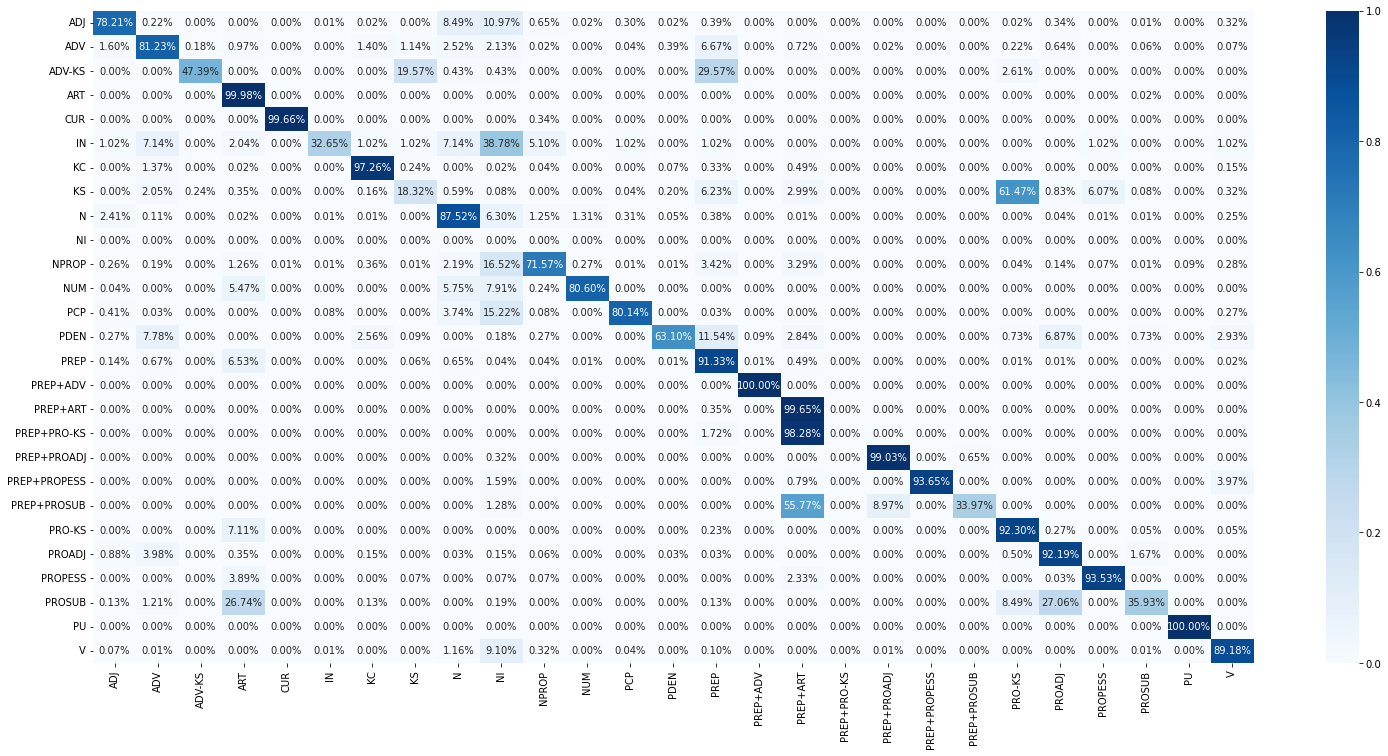

In [92]:
plot_cf_matrix(y_true, y_pred)

Para avaliar o modelo UnigramTagger mantivemos utilizamos os parâmetros padrão da biblioteca. Como visto na tabela acima o modelo atingiu 88,01% de acurácia e 75,09% de recall. O modelo manteve a precisão mais elevada (82,93%), porém a cobertura (recall) ficou mais baixa, com 72,53%. Desta forma, percebemos que o modelo tende a ter menos falso positivos e mais falso negativos. Observando a matriz de confusão, percebemos que que para maioria das taggs o classificador acertou mais de 70% dos casos, porém, para taggs como ADV-KS, IN, KS, PDEN, PREP+PRO-KS, PRE+PROSUB e PROSUB o modelo obteve os resultados mais baixos.

Como vimos, o modelo obteve mais dificuldade para diferenciar a ADV-KS (advérbios conectivos relativos) da tagg KS (conjunção subordinativa) e PREP (preposição) atribuindo 19,57% e 29,57% das taggs KS para cada classe respectivamente. Para a tag IN (interjeição) observamos que o classificador teve dificuldade de classificar, de modo que 38,78% (mais que as taggs corretas 32,65%) receberam o rótulo NI (Não Identificado). Este comportamento pode ser reflexo de uma dificuldade do classificador em lidar com este tipo de tagg. Porém, para obter conclusões assertivas sobre tal hipótese, análises mais profundas que fogem o escopo deste trabalho precisam ser realizadas. Para tagg  PREP+PRO-KS  o classificador obteve o pior desempenho (errou todas as taggs), onde 98,28% das taggs foram assinaladas erroneamente como PREP+ART. Porém, neste caso, é esperado maior dificuldade para o classificador decidir qual tagg aplicar, uma vez que PREP+PRO+KS e PREP+ART partilham grande semelhança semântico (ambas são preposições polilexicais). Por final, o classificador obteve baixo desempenho na classificação de taggs PREP+PROSUB (acertou 33,97% dos casos) e PROSUB (acertou 35,93% dos casos). Para a tagg PREP+PROSUB, houve uma grande influência da tagg PREP+ART (recebeu 55,77% das taggs) e para a PROSUB as taggs ART e PRODADJ foram mais influentes recebendo 26,74% e 27,06% das instâncias.


# BigramTagger
O modelo BigramTagger funciona de forma análoga ao UnigramTagger, porém, escolhe a tag de um token com base em sua string de palavras e na tag das palavras anteriores. Em particular, uma tupla que consiste na tag anterior e a palavra é pesquisada em uma tabela e a tag correspondente é retornada.


In [93]:
if RUN_CLASSIFIERS:
    pred_taggs = BigramTaggerEval(train_taggs, test_sents)
    y_pred = unroll(pred_taggs)
    scores["BigramTagger"] = {}
    scores["BigramTagger"]["metrics"] = eval(y_true, y_pred)
    scores["BigramTagger"]["y_pred"] = y_pred
else:
    y_pred = scores["BigramTagger"]["y_pred"]

In [94]:
pd.DataFrame([scores["BigramTagger"]["metrics"].values()], columns=list(scores["BigramTagger"]["metrics"].keys()))

,accuracy,precision,recall,micro_f1,macro_f1
0,0.324505,0.84822,0.298911,0.324505,0.437354


In [95]:
x = Counter(scores["BigramTagger"]["y_pred"])
x["NI"] / np.sum([ x[key] for key in x ])

0.6561475111143502

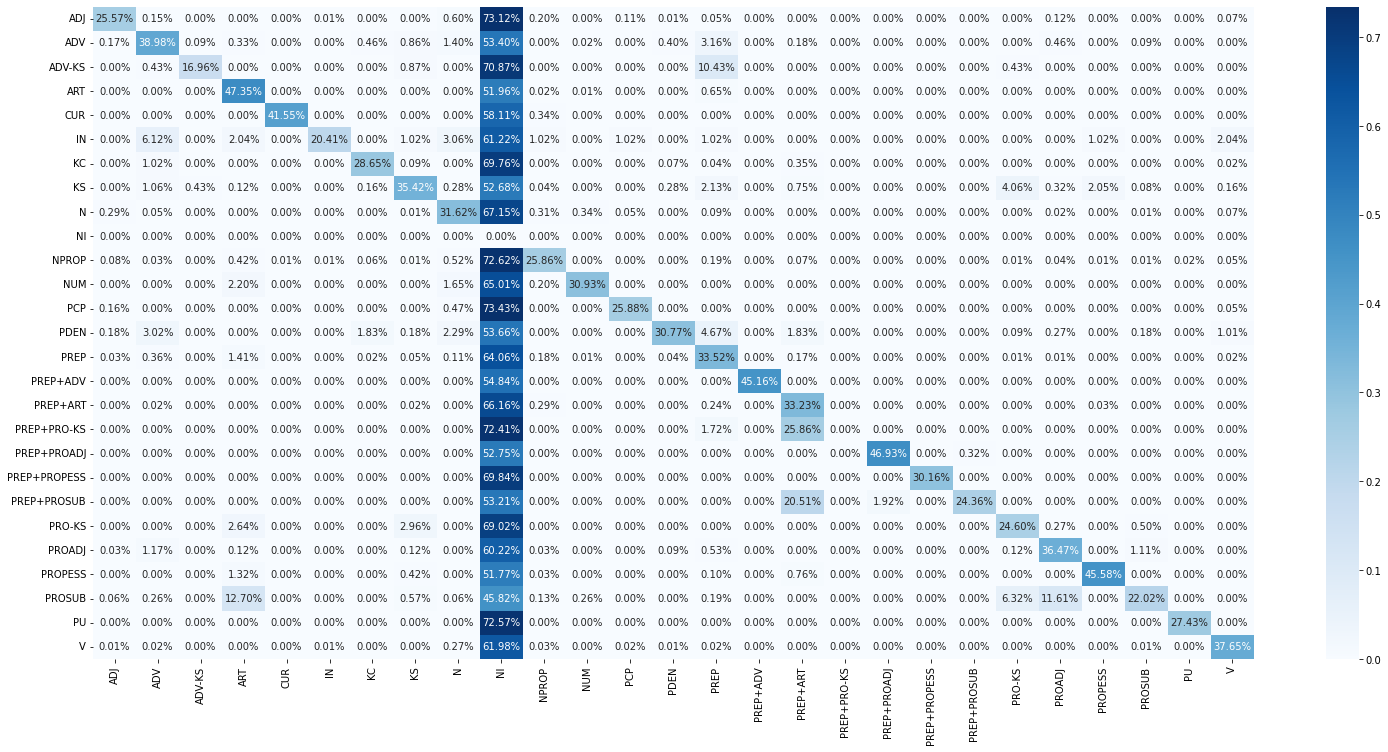

In [96]:
plot_cf_matrix(y_true, y_pred)

Como podemos ver na tabela de scores 2, o obteve baixa acurácia 32,45%, macro f1 43,73%, cobertura 29,89% e micro f1 32,45%. Porém, manteve a precisão relativamente alta (superior ao modelo UnigraTagger). Como podemos ver na matriz de confusão 2 o modelo quando possui muita dificuldade de determinar a tag de uma palavra, assinalando aproximadamente 65,61% das palavras como  NI (Não identificado). Porém, para todas as tags, exceto ADV-KS, PRO-KS e PRO-SUB a classificação do modelo foi enviesada por outra classe. 10,43% das palavras pertencentes a ADV-KS foram atribuídas a classe PREP, 20,51% das pertencentes a PRO-KS foram atribuídas a PREP+ART e 12,70% e 11,61% das palavras das palavras pertencentes a PROSUB foram atribuídas a ART e PROADJ respectivamente. Acreditamos que este modelo tenha tido resultados inferiores ao modelo UnigramTagger devido a falta de informação dos unigramas que possuem forte correlação com a definição da palavra, algo de suma importância para na tarefa de pos tagging. Na seção BigramTaggerBackoff vamos adicionar as informações do UnigramTagger com o Bigrams com a estratégia de backoff e construir um modelo híbrido para avançar os resultados de mabos modelos.

# LookupTagger
O LookupTagger consiste em uma estratégia simples de contagem de palavras, onde, para cada palavra, identifica sua marcação mais frequente e usa essas informações para marcar palavras no próximo texto. Esta estratégia é extremamente sensível aos dados e não generaliza tão bem quanto, visto que sempre aposta na tag de probabilidade maior que é somente definida pela frequência ignorando o contexto.


In [97]:
if RUN_CLASSIFIERS:
    pred_taggs = LookupTaggerEval(nltk.corpus.mac_morpho.words(), unroll_tuples(train_taggs), test_sents)
    y_pred = unroll(pred_taggs)
    scores["LookupTagger"] = {}
    scores["LookupTagger"]["metrics"] = eval(y_true, y_pred)
    scores["LookupTagger"]["y_pred"] = y_pred
else:
    y_pred = scores["LookupTagger"]["y_pred"]

In [98]:
pd.DataFrame([scores["LookupTagger"]["metrics"].values()], columns=list(scores["LookupTagger"]["metrics"].keys()))

,accuracy,precision,recall,micro_f1,macro_f1
0,0.381414,0.565491,0.285579,0.381414,0.329947


In [99]:
x = Counter(scores["LookupTagger"]["y_pred"])
x["NI"] / np.sum([ x[key] for key in x ])

0.5835244123269777

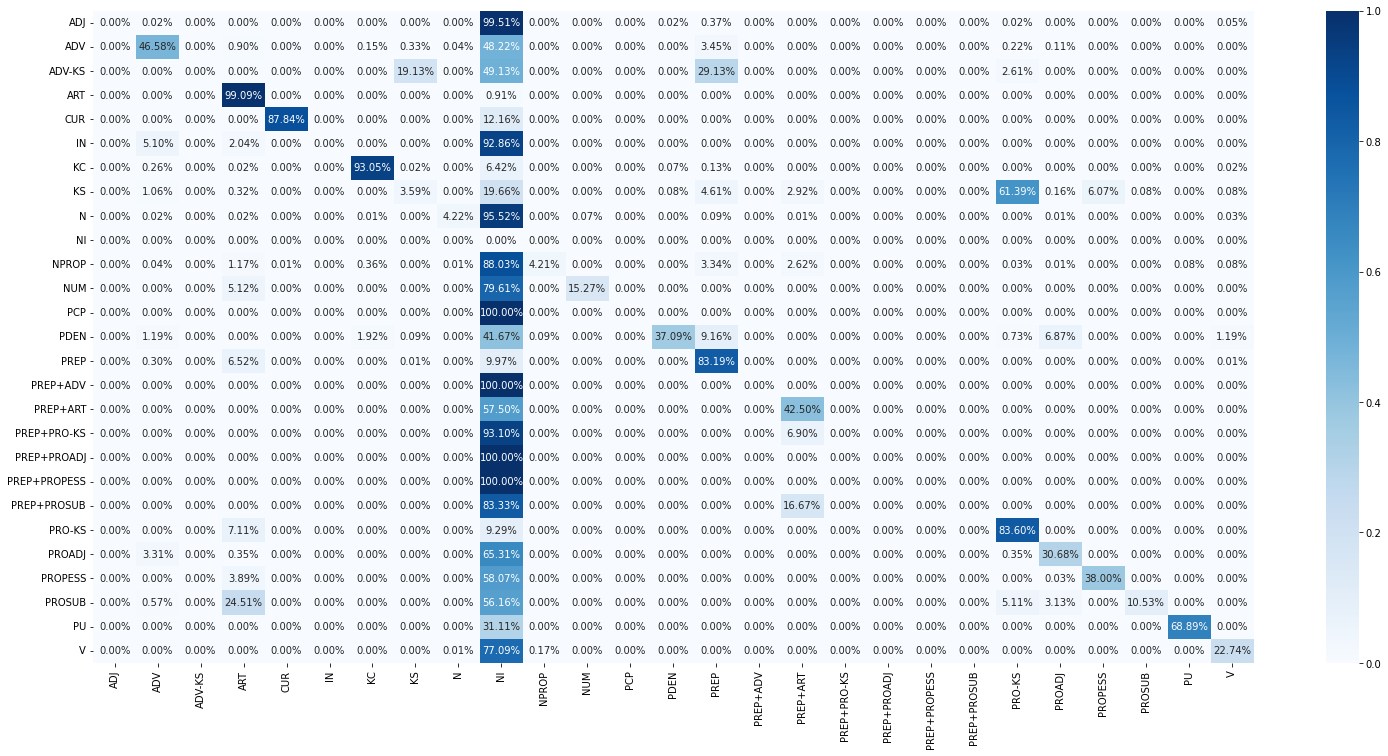

In [100]:
plot_cf_matrix(y_true, y_pred)

Este modelo, diferente dos modelos anteriores não desempenhou bem em nenhum aspecto (acurácia 38,14%, precisão 56,54%, revocação 28,55, micro f1 38,14% e macro f1 32,99) apesar de ter tido acurácia literalmente superior ao BigramTagger.

Dado a característica de ignorar palavras não vistas no treino, o modelo atribuiu a classe NI (Não Identificado) um grande volume de palavras (~ 58,35%). Como não obteve contabilizações destas palavras durante o treino, o modelo assinalou-as como Não Identificado. Para as palavras pertencentes às classes de taggs ART (artigo), CUR (símbolo de moeda corrente), KC (conjunção coordenativa), PREP (preposição), PRO-KS (pronome relativo conectivo) e PU (não definido no glossário) o modelo obteve melhor desempenho. Para estas taggs é esperado que a variabilidade do sentido das palavras deve ser relativamente menor que para outras classes, porém, investigações mais profundas são necessárias.

# ClassifierBasedPOSTagger
ClassifierBasedPOSTagger consiste em um tagger sequencial que usa um classificador interno para escolher a tag para cada token em uma frase. O classificador é alimentado por uma função que faz casamentos por expressão regulares (trabalho com sufixos para detecção de gerúndio, particípio e outros tipos de flexão), usa o histórico dos unigramas, bigramas e trigramas (Híbrido) para gerar os atributos de cada palavra e lançá-las no classificador.


In [101]:
if RUN_CLASSIFIERS:
    pred_taggs = ClassifierBasedPOSTaggerEval(train_taggs, test_sents)
    y_pred = unroll(pred_taggs)
    scores["ClassifierBasedPOSTagger"] = {}
    scores["ClassifierBasedPOSTagger"]["metrics"] = eval(y_true, y_pred)
    scores["ClassifierBasedPOSTagger"]["y_pred"] = y_pred
else:
    y_pred = scores["ClassifierBasedPOSTagger"]["y_pred"]

In [102]:
pd.DataFrame([scores["ClassifierBasedPOSTagger"]["metrics"].values()], columns=list(scores["ClassifierBasedPOSTagger"]["metrics"].keys()))

,accuracy,precision,recall,micro_f1,macro_f1
0,0.913266,0.749388,0.771873,0.913266,0.751925


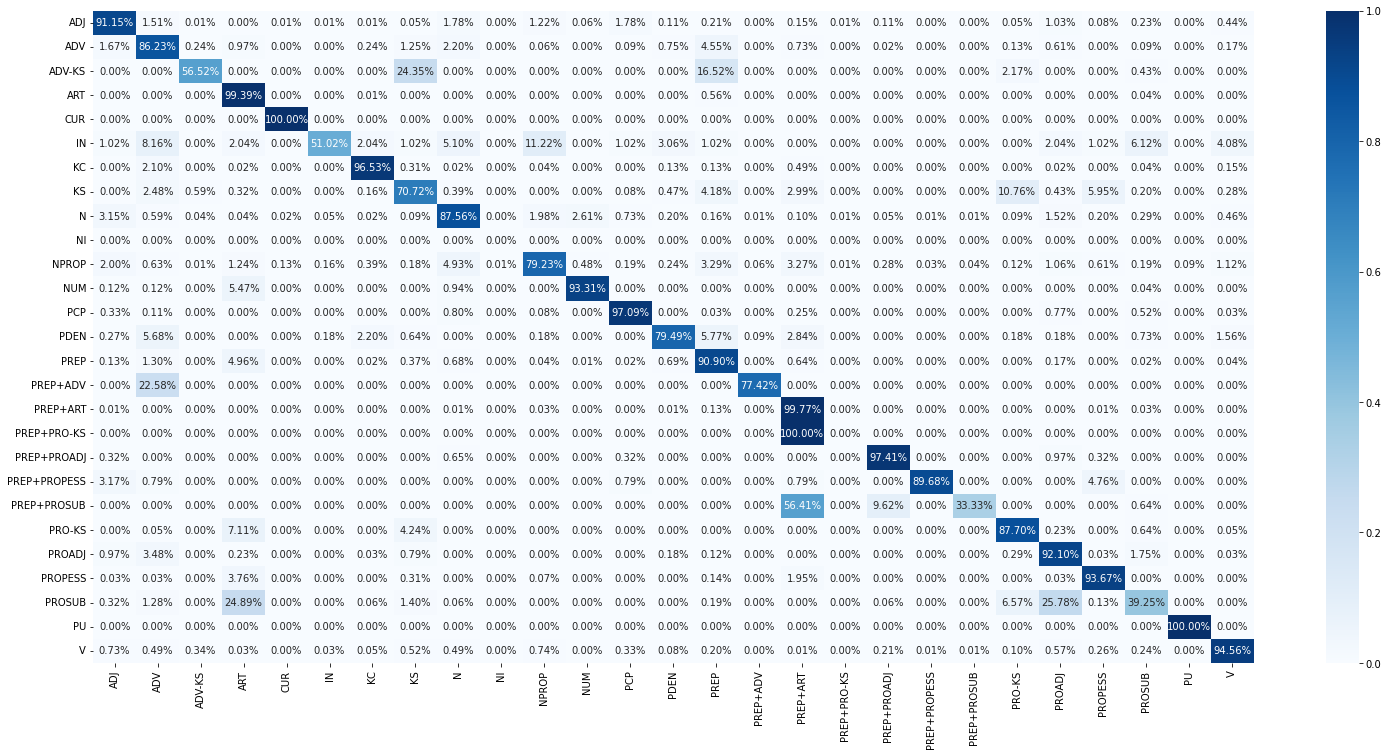

In [103]:
plot_cf_matrix(y_true, y_pred)

O ClassifierBasedPOSTagger obteve a maior acurácia (91,32%) entre todos os modelos avaliados neste trabalho. Mesmo obtendo precisão (74,93%) e revocação (77,18%) relativamente baixo, o modelo se mostrou estável e robusto para lidar com as várias taggs diferentes, exceto as taggs ADV-KS, IN, PREP+PRO-KS, PREP+PROSUB e PROSUB. Apesar de ter obtido resultados baixos para tais taggs, ressaltamos que estas classes são fortemente influenciadas pelas demais similares a esta semanticamente. Para a classe ADV-KS 24,35% das suas instâncias foram assinaladas como KS e 16,52% para a classe PREP. Para a classe IN, as palavras assinaladas erradas ficaram mais distribuídas, sendo somente ADV e NPROP acumulando maiores quantidades das palavras com 8,16% e 11,22% respectivamente, sendo o restante das palavras distribuído nas demais classes de modo que nenhuma acumula mais de 6% das palavras. A classe PREP+PRO-KS assim como para o modelo UnigramTagger, foi onde o classificador obteve o pior resultado e assinalou todas as instâncias como PREP+ART. Porém, como vimos as duas classes são muito próximas semanticamente, logo espera-se que o classificador tenha mais dificuldade para lidar com estes casos. Por final, as classes PREP+PROSUB e PROSUB acumularam erro relativamente alto, sendo a classe PREP+PROSUB influenciada pela classe PREP+ART, onde o classificador assinalou 56,41% das palavras da classe PREP+PROSUB para a classe PREP+ART. Para a classe PROSUB ficou dividida entre as classes ART com 24,89% das instâncias e PROADJ com 25,78%.

# BrillTaggerTrainer
O Tagger Brill é um método indutivo para pos tagging (Eric Brill, 1993). BrillTagger pode ser resumido como um "error-driven transformation-based tagger", uma forma de aprendizado supervisionado, que visa minimizar o erro na assinalação de taggs comum processo baseado em transformação, no sentido de que uma tag é atribuída a cada palavra é alterada usando um conjunto de regras pré-definidas.

No processo de transformação, se a palavra é conhecida, é atribuída a tag mais frequente, ou se a palavra é desconhecida, ingenuamente atribui a tag "noun". A elevação de acurácia é eventualmente alcançada aplicando essas regras de forma iterativa e alterando as tags incorretas. Essa abordagem garante que informações valiosas, como a construção morfossintática de palavras, sejam empregadas em um processo de marcação automática.


In [104]:
if RUN_CLASSIFIERS:
    pred_taggs = BrillTaggerTrainerEval(uni_model, train_taggs, test_sents)
    y_pred = unroll(pred_taggs)
    scores["BrillTaggerTrainer"] = {}
    scores["BrillTaggerTrainer"]["metrics"] = eval(y_true, y_pred)
    scores["BrillTaggerTrainer"]["y_pred"] = y_pred
else:
    y_pred = scores["BrillTaggerTrainer"]["y_pred"]

In [105]:
pd.DataFrame([scores["BrillTaggerTrainer"]["metrics"].values()], columns=list(scores["BrillTaggerTrainer"]["metrics"].keys()))

,accuracy,precision,recall,micro_f1,macro_f1
0,0.909728,0.892944,0.82853,0.909728,0.854238


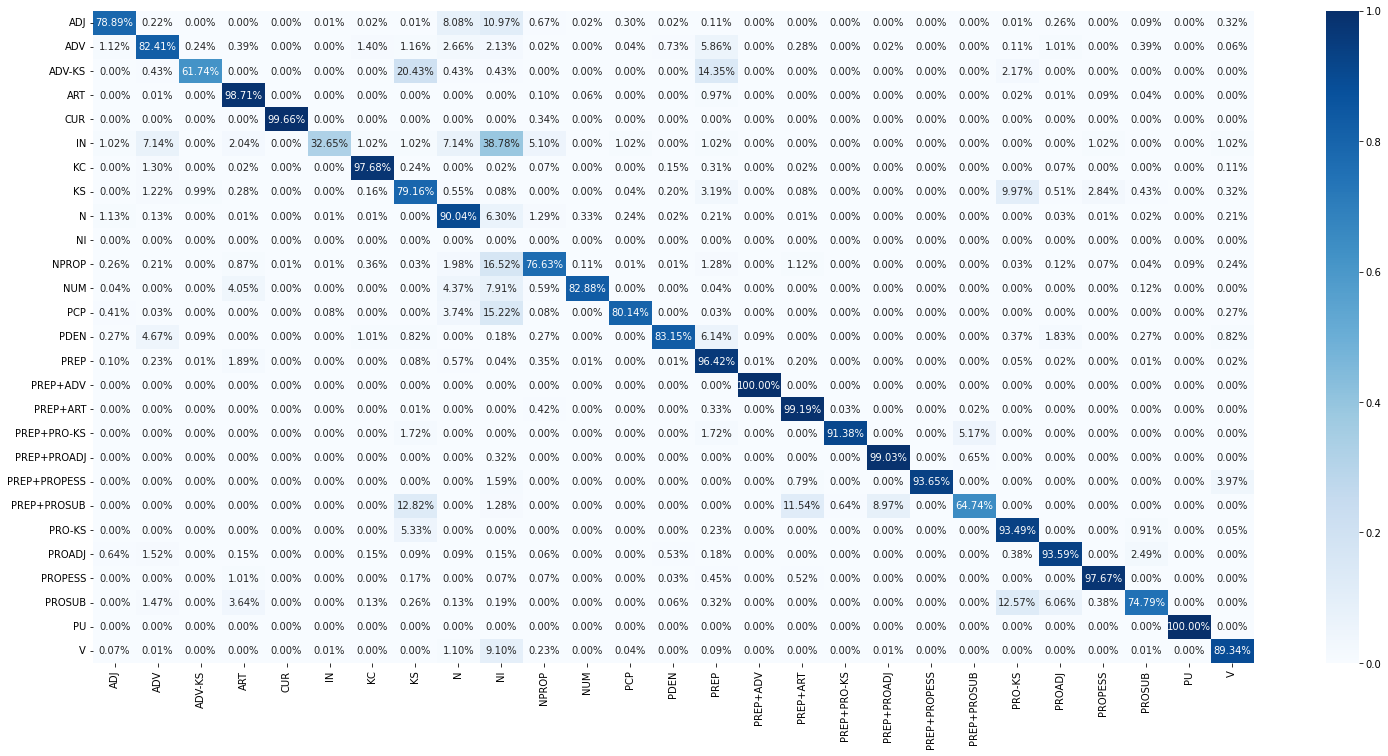

In [106]:
plot_cf_matrix(y_true, y_pred)

O modelo BrillTagger foi o modelo que apresentou mais estabilidade entre todos os modelos avaliados neste estudo, ficando com o segundo melhor desempenho em termos de acurácia ~ 90,97%, e melhor desempenho em precisão ~ 89,29%, revocação ~82,85%, micro f1 ~ 90,97% e macro f1 ~ 85,42%. Diferente dos modelos estudados anteriormente, as únicas classes que sofreram influência de outra classe foram ADV-KS, PREP+PROSUB e PROSUB. Para a classe ADV-KS 20,43% das palavras desta classe foram assinaladas como KS, o que é esperado devido a similaridade semântica entre as classes. Porém, ainda sim, a influência de KS em ADV-KS é bem menor do que o ocorrido nos demais modelos. Para as classes PREP+PROSUB e PROSUB a influência de outras classes ocorreu, porém com menor intensidade, com a classe PREP+PROSUB tendo 12,82% assinaladas como KS e a classe PROSUB com 12,75% das suas palavras assinaladas como PRO-KS. Outra vez, esse comportamento também foi observado nos demais modelos, porém com bem mais intensidade de influência das classes. Vale notar também, que este algoritmo se saiu muito bem para a classe PREP+PRO-KS acertando 91,38% das rotulações sendo nenhuma das palavras assinaladas como da classe PREP+ART ou como NI, diferente dos demais modelos onde grandes parcelas das palavras de PREP+PRO-KS eram assinaladas como PREP+ART, sendo para o modelo Classifier Based todas as palavras assinaladas de tal forma. Para as classes IN, NPROP e PCP o modelo ficou consideravelmente indeciso. Principalmente para a classe IN, onde ~ 38,78% (mais que os 32,65% assinaladas corretamente) das palavras foram assinaladas como NI. Para NPROP e PCP o efeito foi similar, porém em menor intensidade, com 16,25% e 15,22% assinaladas como NI respectivamente. Para as demais classes o erro do classificador foi baixo e distribuído, sem uma relação clara entre duas ou mais classes.

# BigramTagger Backoff

É um dos recursos mais importantes do SequentialBackoffTagger, pois permite combinar diferentes taggers (classificadores). A vantagem de fazer isso é que, se um tagger não souber sobre a marcação de uma palavra, ele poderá passar essa tarefa de marcação para o próximo tagger de backoff. Se esse não puder fazer isso, ele pode passar a palavra para o próximo tagger e assim por diante até que não haja mais taggers de recuo para verificar. Nesta seção vamos utilizar o BigramTagger unido ao UnigramTagger para construir um classificador mais forte. Para tal análise utilizaremos o UnigramTagger como backoff do BigramTagger. Utilizamos tal configuração, pois como mostrado anteriormente o BigramTagger foi um modelo que mostrou grande indecisão na classificação, assinalando ~ 65,61% das palavras como Não Identificado NI e também por funcionar de forma similar ao UnigramTagger. Desta forma nosso objetivo é verificar se conseguimos um modelo híbrido mais forte.

In [107]:
if RUN_CLASSIFIERS:
    pred_taggs = BigramTaggerEval(train_taggs, test_sents, backoff=uni_model)
    y_pred = unroll(pred_taggs)
    scores["BigramTaggerBackoff"] = {}
    scores["BigramTaggerBackoff"]["metrics"] = eval(y_true, y_pred)
    scores["BigramTaggerBackoff"]["y_pred"] = y_pred
else:
    y_pred = scores["BigramTaggerBackoff"]["y_pred"]

In [108]:
m = pd.DataFrame([scores["UnigramTagger"]["metrics"].values(),
              scores["BigramTagger"]["metrics"].values(),
              scores["BigramTaggerBackoff"]["metrics"].values()], columns=list(scores["BigramTaggerBackoff"]["metrics"].keys()))
m["clfs"] = ["UnigramTagger", "BigramTagger", "BigramTaggerBackoff (Híbrido)"]
m

,accuracy,precision,recall,micro_f1,macro_f1,clfs
0,0.880010,0.829393,0.725335,0.880010,0.750968,UnigramTagger
1,0.324505,0.848220,0.298911,0.324505,0.437354,BigramTagger
2,0.897983,0.837510,0.754213,0.897983,0.783873,BigramTaggerBackoff (Híbrido)


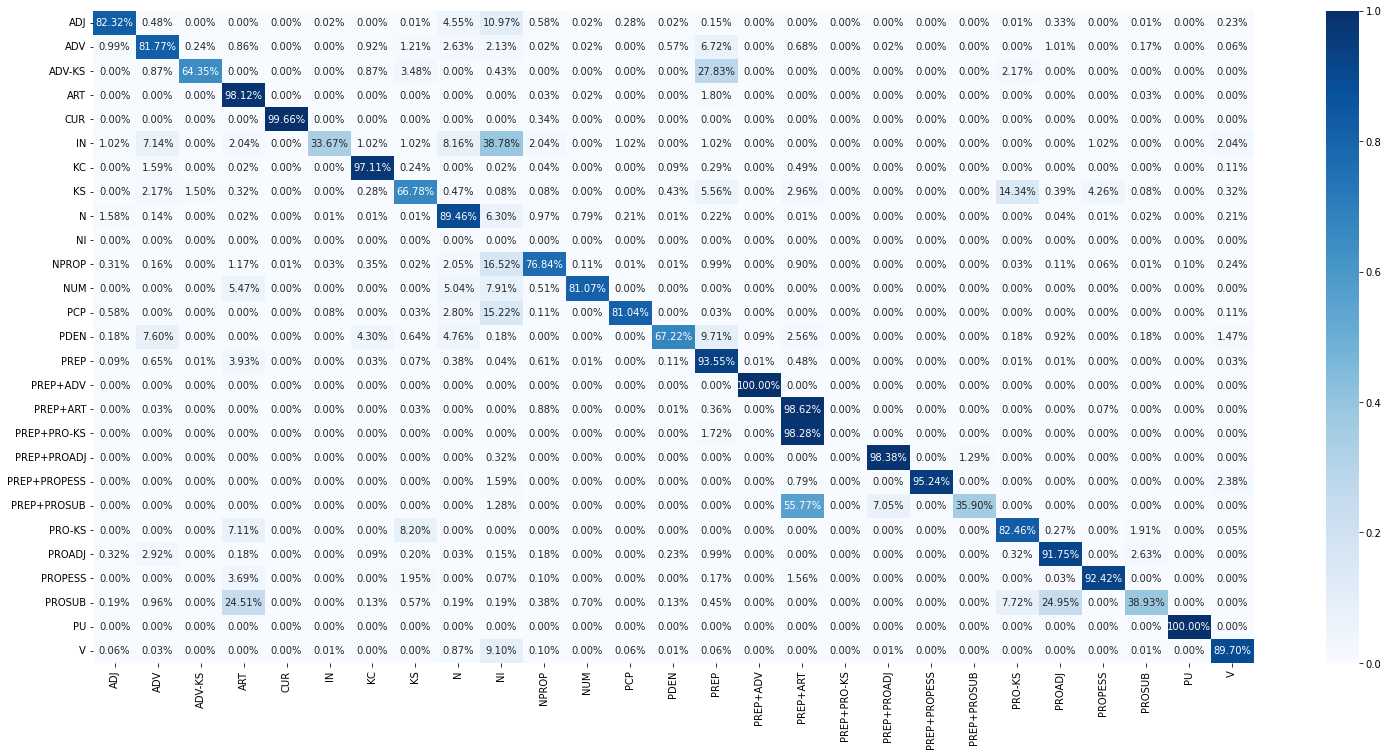

In [109]:
plot_cf_matrix(y_true, y_pred)

Como podemos ver na tabela acima, o modelo híbrido é ligeiramente superior aos modelos UnigramTagger e BigramTagger. A principal melhoria foi no recall que aumentou de 72,53% (UnigramTagger) para 75,42% com o modelo híbrido. O avanço do modelo híbrido é claramente perceptível na matriz de confusão acima, uma vez que ele é poucas instâncias foram assinaladas como NI, principal problema ocorrente no BigramTagger, porém não expressivo no UnigraTagger. Isso nos mostra como os modelos combinados superam limitações intrínsecas de cada um.

In [110]:
if RUN_CLASSIFIERS:
    with open("output/results.json", "w") as fd:
        json.dump(scores, fd, indent=6)
    

# Comparando Modelos

In [111]:
def color(idx):
    if idx % 2 == 0:
        return "orange"
    return "blue"

def getx(start, gap, n_iter):
    
    x = []
    value_x = start
    for i in range(n_iter):
        x.append(value_x)
        value_x += gap
    return x

def plot_score(scores, metric="precision", start=0, gap=2, color="blue"):

    y = []
    x_ticks_labels = []
    for clf in scores:
        y.append(scores[clf]["metrics"][metric]*100)
        x_ticks_labels.append(clf)
    nclfs = len(list(scores.keys()))
    x = getx(start, gap, nclfs)
    plt.bar(x, y, color=color, width=0.4, label=metric)

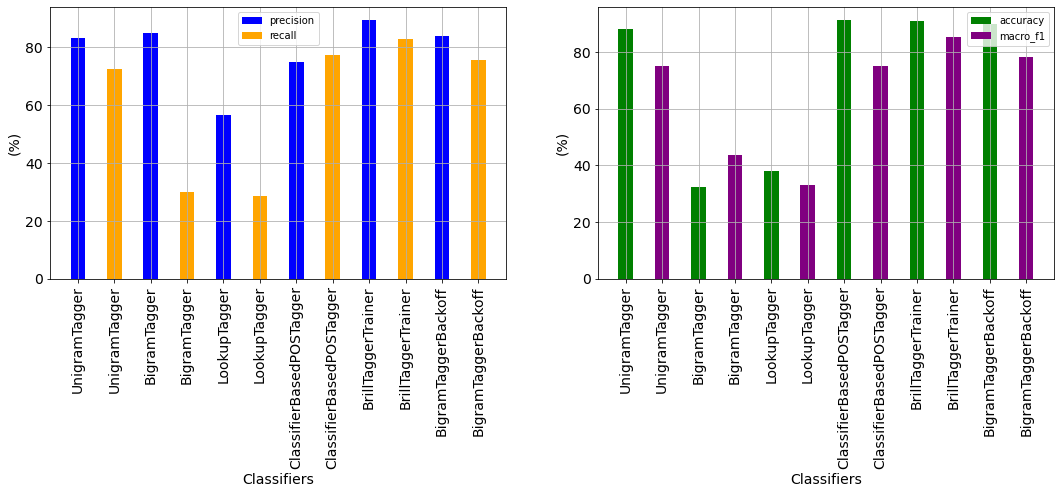

In [112]:
gap = 2
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
plot_score(scores)
plot_score(scores, metric="recall", start=1, color="orange")
clfs = []
for clf in scores.keys():
    clfs += [clf] * 2
x = np.arange(len(clfs))
plt.xticks(ticks=x, labels=clfs, rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classifiers", fontsize=14)
plt.ylabel("(%)", fontsize=14)
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plot_score(scores, metric="accuracy", color="green")
plot_score(scores, metric="macro_f1", start=1, color="purple")
x = np.arange(len(clfs))
plt.xticks(ticks=x, labels=clfs, rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classifiers", fontsize=14)
plt.ylabel("(%)", fontsize=14)
plt.legend()
plt.grid()

Como podemos ver, no gráfico de barras acima, os o classificador BrillTagger obteve os melhores resultados em termos de precisão, seguido do modelo híbrido (BrillTaggerBackoff), BigramTagger, UnigramTagger sem backoff, ClassifierBased e por final LookupTagger. Observando o recall a ordem permanece a mesma, porém, o modelo BigramTagger sofre forte queda de desempenho e sai do segundo melhor desempenho para o quarto, ficando somente a frente do LookupTagger.
Observando a acurácia, o modelo Classifier Based ficou empatado estatisticamente com o modelo BrillTagger, Híbrido e UnigramTagger. Porém, ao se tratar de macro F1, BrillTagger permanece superior aos demais modelos e também mais estável. BigramTagger e LookupTagger desempenharam pior respectivamente.

# Conclusão

Neste trabalho avaliamos diferentes modelos de pos-tagging sobre o corpus em lingua portuguesa Mac-Morpho. A partir de nossas análises verificamos a forte influência de algumas classes (taggs) sobre outras na decisão de classificadores. Exemplo deste comportamento ocorreu com as classe PREP+PRO+KS que sofreu forte influência da classe PREP+ART para os modelos ClassifierBasedTagger e LookupTagger. Mostramos também que os classificadores BigramTagger e LookupTagger apresentam alto nível de incerteza na classificação, assinalando 65,61% e 58,35% das palavras como NI, Não Identificado. Por final, os experimentos aqui realizados mostram indícios que o classificador BrillTagger é o melhor modelo dentre os avaliados neste trabalho. Os classificadores UnigramTagger e ClassifierBased desempenharam relativamente bem em relação ao melhor classificador.
